In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torchmetrics.functional.detection.iou import intersection_over_union
import numpy as np
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as T
from torch import nn, optim
from torchmetrics.classification import BinaryJaccardIndex
from tqdm import tqdm

In [3]:
DEVICE = 'mps'
DEVICE

'mps'

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("quadeer15sh/augmented-forest-segmentation")

print("Path to dataset files:", path)

/Users/igor/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 172M/172M [00:05<00:00, 31.6MB/s] 

Extracting files...


Path to dataset files: /Users/igor/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2


In [4]:
class NewDataSet(Dataset):
    def __init__(self, csv_file, image_dir, mask_dir, img_transform, mask_transform):
        self.csv_file = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
       
        
    def __len__(self):
        return len(self.csv_file) 
    
    def __getitem__(self, idx):    
        img_name = self.csv_file.iloc[idx]['image']
        mask_name = self.csv_file.iloc[idx]['mask']

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")   
        mask = Image.open(mask_path).convert("L")



        if self.img_transform:
            image = self.img_transform(image)
        else:
            image = T.ToTensor()(image)
            
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = T.ToTensor()(mask)
            
        return image, mask


In [5]:
img_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
    T.ToTensor(),
    T.Lambda(lambda x: (x > 0.5).float())  
])

In [6]:
dataset = NewDataSet(
    csv_file='/Users/igor/ds_bootcamp/tumor/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented/Forest Segmented/meta_data.csv',
    image_dir='/Users/igor/ds_bootcamp/tumor/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented/Forest Segmented/images',
    mask_dir='/Users/igor/ds_bootcamp/tumor/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented/Forest Segmented/masks',
    img_transform=img_transform,
    mask_transform=mask_transform
)

In [7]:
train_dataset, valid_dataset = train_test_split(dataset)

In [9]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=8)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=8)



In [10]:
img, msk = next(iter(train_loader))


In [11]:
img.shape

torch.Size([8, 3, 256, 256])

In [12]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out
    
    def fit(self, optimizer, criterion_msk, epochs, train_loader, valid_loader):
        iou_metric = BinaryJaccardIndex().to(DEVICE)
        log = dict()
        

        log['epoch_train_mask_loss'] = []
        log['epoch_valid_mask_loss'] = []

        log['epoch_train_iou'] = []
        log['epoch_valid_iou'] = []

        for epoch in range(epochs):
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)

            batch_mask_loss_train = []

            self.train()
            iou_metric.reset() 
            for img, mask in  progress_bar:
                img = img.to(DEVICE)
                mask = mask.to(DEVICE)

                coords = self(img)

                loss_mask = criterion_msk(coords, mask)

                loss_mask.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                iou_metric.update(coords, mask)
                

                batch_mask_loss_train.append(loss_mask.item())


            epoch_iou = iou_metric.compute().item()
            log['epoch_train_mask_loss'].append(np.mean(batch_mask_loss_train))
            log['epoch_train_iou'].append(epoch_iou)

            self.eval()
            iou_metric.reset()
            batch_mask_loss_valid = []
            for img, mask in valid_loader:
                img = img.to(DEVICE)
                mask = mask.to(DEVICE)

                with torch.inference_mode():
                    coords = self(img)

                loss_mask = criterion_msk(coords, mask)

                iou_metric.update(coords, mask)

                # accuracy = (logits.argmax(1) == labels.squeeze()).sum()/labels.size(0)


                batch_mask_loss_valid.append(loss_mask.item())

            epoch_iou_val = iou_metric.compute().item()
            log['epoch_valid_mask_loss'].append(np.mean(batch_mask_loss_valid))
            log['epoch_valid_iou'].append(epoch_iou_val)

            print(f"Epoch {epoch + 1} Train stage:  mask_loss: {log['epoch_train_mask_loss'][-1]:.3f}  iou: {log['epoch_train_iou'][-1]:.3f}")
            print(f"Epoch {epoch + 1} valid stage:  mask_loss: {log['epoch_valid_mask_loss'][-1]:.3f}  iou: {log['epoch_valid_iou'][-1]:.3f}")
        return log





In [13]:
model = UNet(1)
model.to(DEVICE)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

In [14]:
optimizer = optim.Adam(model.parameters())
criterion_msk = nn.BCEWithLogitsLoss()

In [ ]:
model.fit(optimizer, criterion_msk, 1, train_loader, valid_loader)

Epoch 1:   0%|          | 0/479 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 479/479 [07:23<00:00,  1.08it/s]


Epoch 1 Train stage:  mask_loss: 0.603  iou: 0.600
Epoch 1 valid stage:  mask_loss: 0.586  iou: 0.641


{'epoch_train_mask_loss': [np.float64(0.6033204923965239)],
 'epoch_valid_mask_loss': [np.float64(0.5863819958642125)],
 'epoch_train_iou': [0.6003857851028442],
 'epoch_valid_iou': [0.6411193013191223]}

torch.Size([8, 3, 256, 256])

torch.Size([8, 3, 256, 256])

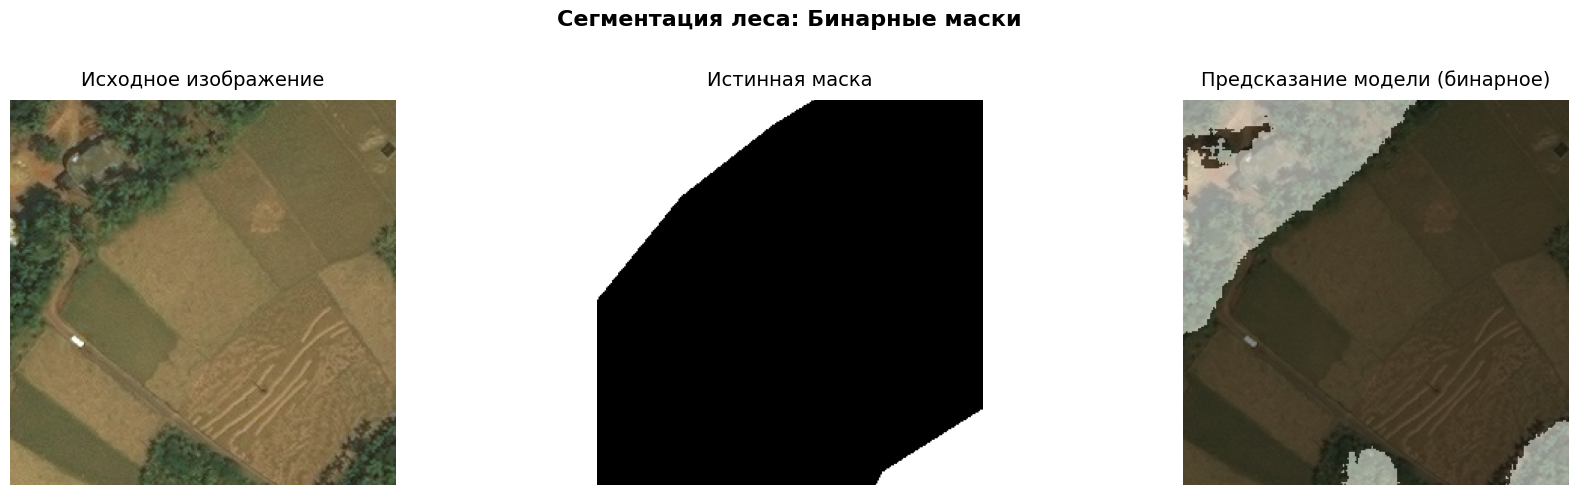

In [27]:
import matplotlib.pyplot as plt
import torch

# Получаем и обрабатываем данные
img_batch, mask_batch = next(iter(train_loader))
img_batch = img_batch.to(DEVICE)
with torch.no_grad():
    pred_logits = model(img_batch)
    pred_prob = torch.sigmoid(pred_logits)  # Логиты → вероятности

# Порог бинаризации (0.5 — стандарт для BCEWithLogitsLoss)
threshold = 0.5

# Берём первый пример и переносим на CPU
img = img_batch[0].cpu().permute(1, 2, 0)          # [H, W, C]
true_mask = mask_batch[0, 0].cpu()                # [H, W]
pred_mask_binary = (pred_prob[0, 0].cpu() > threshold).float()  # Бинарная маска [H, W]

# Создаём красивую визуализацию
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Сегментация леса: Бинарные маски', fontsize=16, fontweight='bold')

# 1. Исходное изображение
axes[0].imshow(img)
axes[0].set_title('Исходное изображение', fontsize=14, pad=10)
axes[0].axis('off')

# 2. Истинная маска (бинарная)
axes[1].imshow(true_mask, cmap='gray')
axes[1].set_title('Истинная маска', fontsize=14, pad=10)
axes[1].axis('off')

# 3. Предсказанная бинарная маска
axes[2].imshow(img)
axes[2].imshow(pred_mask_binary, cmap='gray', alpha=0.5, vmin=0, vmax=1)
axes[2].set_title('Предсказание модели (бинарное)', fontsize=14, pad=10)
axes[2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [18]:
model = UNet(n_class=1)
model.load_state_dict(torch.load("/Users/igor/ds_bootcamp/tumor/model_unet.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval() 

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(